Trial 01: best=5850 gen=20 time=0.18s peso=2990
Trial 02: best=5850 gen=83 time=0.14s peso=2990
Trial 03: best=5850 gen=18 time=0.14s peso=2990
Trial 04: best=5850 gen=19 time=0.13s peso=2980
Trial 05: best=5850 gen=50 time=0.12s peso=2970
Trial 06: best=5850 gen=38 time=0.12s peso=2990
Trial 07: best=5850 gen=16 time=0.12s peso=2970
Trial 08: best=5850 gen=53 time=0.13s peso=2980
Trial 09: best=5800 gen=75 time=0.14s peso=2980
Trial 10: best=5850 gen=4 time=0.16s peso=2990
Trial 11: best=5800 gen=26 time=0.14s peso=2980
Trial 12: best=5800 gen=89 time=0.16s peso=2890
Trial 13: best=5800 gen=30 time=0.15s peso=2890
Trial 14: best=5850 gen=87 time=0.13s peso=2980
Trial 15: best=5850 gen=27 time=0.14s peso=2980
Trial 16: best=5800 gen=43 time=0.15s peso=2880
Trial 17: best=5850 gen=21 time=0.14s peso=2990
Trial 18: best=5850 gen=35 time=0.20s peso=2990
Trial 19: best=5850 gen=53 time=0.15s peso=2980
Trial 20: best=5850 gen=18 time=0.14s peso=2990
Trial 21: best=5850 gen=75 time=0.14s pes

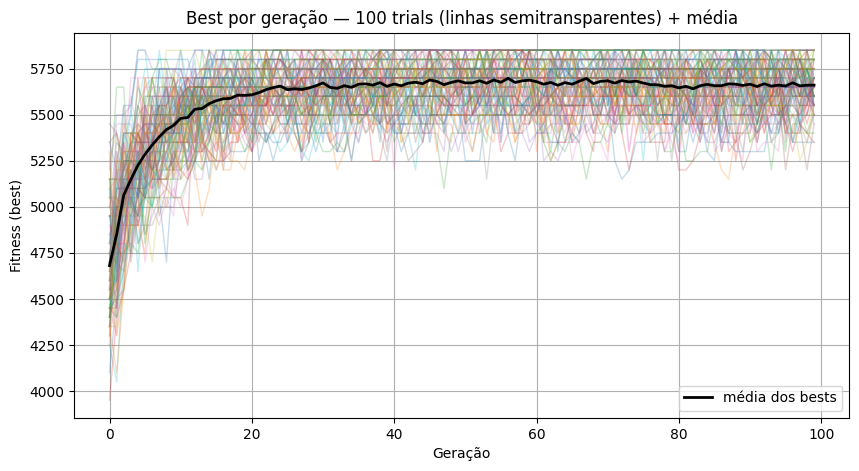

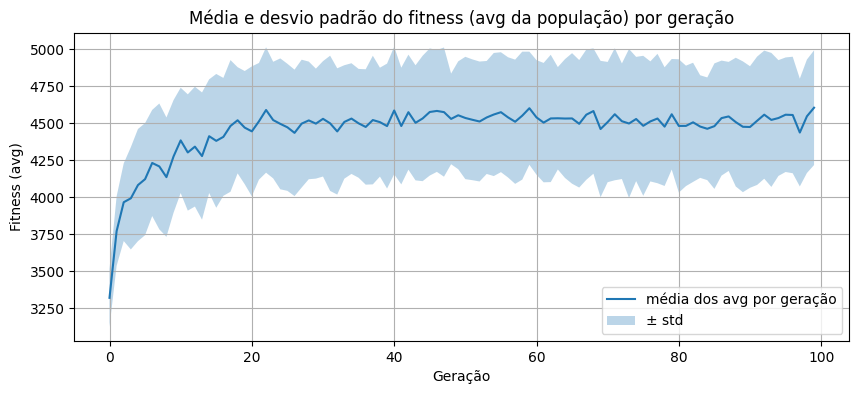

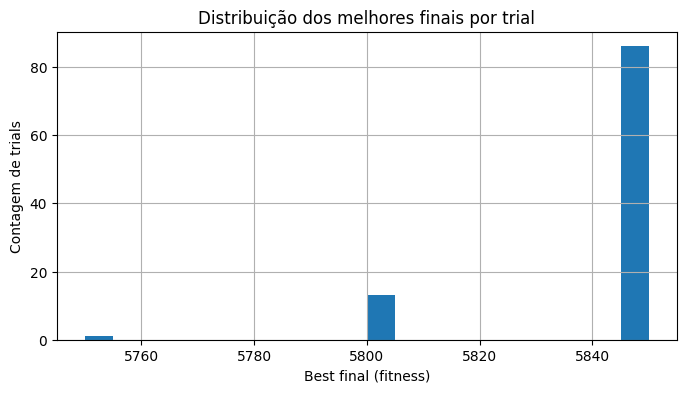

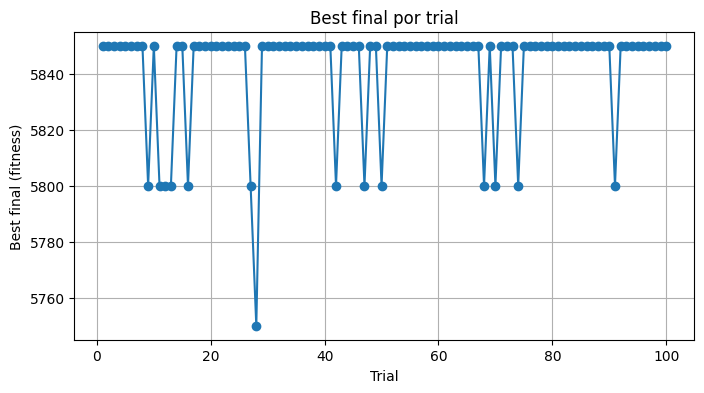


=== Resumo agregado ===
Média dos best finais: 5842.50
Mediana dos best finais: 5850.00
Melhor entre todos os trials: 5850 (trial 1)
Pior entre todos os trials: 5750 (trial 28)
Tempo total (s): 12.28


In [3]:
# ga_experiments_plot.py
"""
Roda vários trials do GA (versão simples) e EXIBE resultados com matplotlib.
Não salva CSVs.
Ajuste parâmetros na seção CONFIG.
"""

import time
import numpy as np
import matplotlib.pyplot as plt

# ------------- CONFIG -------------
N_TRIALS = 100
GERACOES = 100
POP_SIZE = 20
MUT_RATE = 0.05
TORNEIO = 3
ELITISMO = False
BASE_SEED = None    # None => seeds aleatórias
SHOW_INDIVIDUAL = False  # True para abrir um plot por trial (pode ser muitos)
# -----------------------------------

pesos_dos_objetos = np.array([350,250,160,120,200,100,120,220,40,80,100,300,180,250,220,150,280,310,120,160,110,210])
valor_dos_objetos = np.array([300,400,450,350,250,300,200,250,150,400,350,300,450,500,350,400,200,300,250,300,150,200])
PESO_MAX = 3000
GENOME = len(pesos_dos_objetos)

def fitness(ind):
    p = ind.dot(pesos_dos_objetos)
    v = ind.dot(valor_dos_objetos)
    return 0 if p > PESO_MAX else v

def torneio(pop, fits):
    idx = np.random.choice(len(pop), TORNEIO, replace=False)
    return pop[idx[np.argmax(fits[idx])]]

def crossover(a, b):
    pt = np.random.randint(1, GENOME-1)
    return np.concatenate((a[:pt], b[pt:])), np.concatenate((b[:pt], a[pt:]))

def muta(ind):
    for i in range(GENOME):
        if np.random.rand() < MUT_RATE:
            ind[i] = 1 - ind[i]
    return ind

def run_trial(seed=None):
    if seed is not None:
        np.random.seed(seed)
    pop = np.random.randint(2, size=(POP_SIZE, GENOME)).astype(int)
    best_global = 0
    best_sol = np.zeros(GENOME, dtype=int)
    gen_best = 0

    bests = np.zeros(GERACOES, dtype=int)
    avgs  = np.zeros(GERACOES, dtype=float)
    worst = np.zeros(GERACOES, dtype=int)

    t0 = time.time()
    for g in range(GERACOES):
        fits = np.array([fitness(ind) for ind in pop])
        bests[g] = int(fits.max())
        avgs[g]  = float(fits.mean())
        worst[g] = int(fits.min())

        if fits.max() > best_global:
            best_global = int(fits.max())
            best_sol = pop[np.argmax(fits)].copy()
            gen_best = g

        # reprodução
        if ELITISMO:
            elite = pop[np.argmax(fits)].copy()
            new_pop = [elite]
            while len(new_pop) < POP_SIZE:
                p1 = torneio(pop, fits)
                p2 = torneio(pop, fits)
                c1, c2 = crossover(p1, p2)
                new_pop.append(muta(c1.astype(int)))
                if len(new_pop) < POP_SIZE:
                    new_pop.append(muta(c2.astype(int)))
            pop = np.array(new_pop[:POP_SIZE])
        else:
            new_pop = []
            while len(new_pop) < POP_SIZE:
                p1 = torneio(pop, fits)
                p2 = torneio(pop, fits)
                c1, c2 = crossover(p1, p2)
                new_pop.append(muta(c1.astype(int)))
                if len(new_pop) < POP_SIZE:
                    new_pop.append(muta(c2.astype(int)))
            pop = np.array(new_pop[:POP_SIZE])

    t1 = time.time()
    peso = int(best_sol.dot(pesos_dos_objetos))
    return {
        "best_final": best_global,
        "geracao_do_best": gen_best,
        "peso_total": peso,
        "tempo": t1 - t0,
        "bests": bests,
        "avgs": avgs,
        "worst": worst
    }

def main():
    all_bests = np.zeros((N_TRIALS, GERACOES), dtype=int)
    all_avgs  = np.zeros((N_TRIALS, GERACOES), dtype=float)
    final_bests = np.zeros(N_TRIALS, dtype=int)
    gen_of_best  = np.zeros(N_TRIALS, dtype=int)
    tempos = np.zeros(N_TRIALS, dtype=float)
    pesos = np.zeros(N_TRIALS, dtype=int)

    for i in range(N_TRIALS):
        seed = None if BASE_SEED is None else BASE_SEED + i
        r = run_trial(seed=seed)
        all_bests[i,:] = r["bests"]
        all_avgs[i,:]  = r["avgs"]
        final_bests[i] = r["best_final"]
        gen_of_best[i] = r["geracao_do_best"]
        tempos[i] = r["tempo"]
        pesos[i] = r["peso_total"]
        print(f"Trial {i+1:02d}: best={final_bests[i]} gen={gen_of_best[i]} time={tempos[i]:.2f}s peso={pesos[i]}")

        if SHOW_INDIVIDUAL:
            plt.figure(figsize=(8,3))
            plt.plot(r["bests"], label="best")
            plt.plot(r["avgs"],  label="avg")
            plt.title(f"Trial {i+1:02d} — best final {final_bests[i]}")
            plt.xlabel("Geração")
            plt.ylabel("Fitness")
            plt.legend()
            plt.grid(True)
            plt.show()

    # Plot 1: linhas de best por geração (cada trial) + média
    plt.figure(figsize=(10,5))
    for i in range(N_TRIALS):
        plt.plot(all_bests[i], alpha=0.25, linewidth=1)
    mean_bests = all_bests.mean(axis=0)
    plt.plot(mean_bests, color="black", linewidth=2, label="média dos bests")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (best)")
    plt.title(f"Best por geração — {N_TRIALS} trials (linhas semitransparentes) + média")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: média ± std do fitness da população por geração
    mean_avgs = all_avgs.mean(axis=0)
    std_avgs  = all_avgs.std(axis=0)
    plt.figure(figsize=(10,4))
    plt.plot(mean_avgs, label="média dos avg por geração")
    plt.fill_between(np.arange(GERACOES), mean_avgs - std_avgs, mean_avgs + std_avgs, alpha=0.3, label="± std")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (avg)")
    plt.title("Média e desvio padrão do fitness (avg da população) por geração")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: histograma dos melhores finais
    plt.figure(figsize=(8,4))
    plt.hist(final_bests, bins='auto')
    plt.xlabel("Best final (fitness)")
    plt.ylabel("Contagem de trials")
    plt.title("Distribuição dos melhores finais por trial")
    plt.grid(True)
    plt.show()

    # Plot 4: best por trial (scatter)
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(1, N_TRIALS+1), final_bests, marker='o', linestyle='-')
    plt.xlabel("Trial")
    plt.ylabel("Best final (fitness)")
    plt.title("Best final por trial")
    plt.grid(True)
    plt.show()

    # Print resumo estatístico
    print("\n=== Resumo agregado ===")
    print(f"Média dos best finais: {final_bests.mean():.2f}")
    print(f"Mediana dos best finais: {np.median(final_bests):.2f}")
    print(f"Melhor entre todos os trials: {final_bests.max()} (trial {np.argmax(final_bests)+1})")
    print(f"Pior entre todos os trials: {final_bests.min()} (trial {np.argmin(final_bests)+1})")
    print(f"Tempo total (s): {tempos.sum():.2f}")

if __name__ == "__main__":
    main()


Trial 01: best=5850 gen=39 time=0.12s peso=2980
Trial 02: best=5650 gen=20 time=0.11s peso=2980
Trial 03: best=5850 gen=21 time=0.11s peso=2980
Trial 04: best=5850 gen=26 time=0.11s peso=2990
Trial 05: best=5850 gen=47 time=0.11s peso=2970
Trial 06: best=5850 gen=35 time=0.10s peso=2990
Trial 07: best=5750 gen=36 time=0.10s peso=3000
Trial 08: best=5850 gen=49 time=0.11s peso=2970
Trial 09: best=5850 gen=14 time=0.11s peso=2980
Trial 10: best=5850 gen=64 time=0.11s peso=2990
Trial 11: best=5850 gen=31 time=0.11s peso=2990
Trial 12: best=5850 gen=17 time=0.12s peso=2990
Trial 13: best=5750 gen=51 time=0.12s peso=2960
Trial 14: best=5850 gen=82 time=0.12s peso=2970
Trial 15: best=5750 gen=7 time=0.10s peso=2990
Trial 16: best=5850 gen=52 time=0.11s peso=2980
Trial 17: best=5850 gen=15 time=0.10s peso=2990
Trial 18: best=5850 gen=8 time=0.10s peso=2990
Trial 19: best=5850 gen=23 time=0.12s peso=2970
Trial 20: best=5850 gen=70 time=0.10s peso=2980
Trial 21: best=5850 gen=21 time=0.11s peso

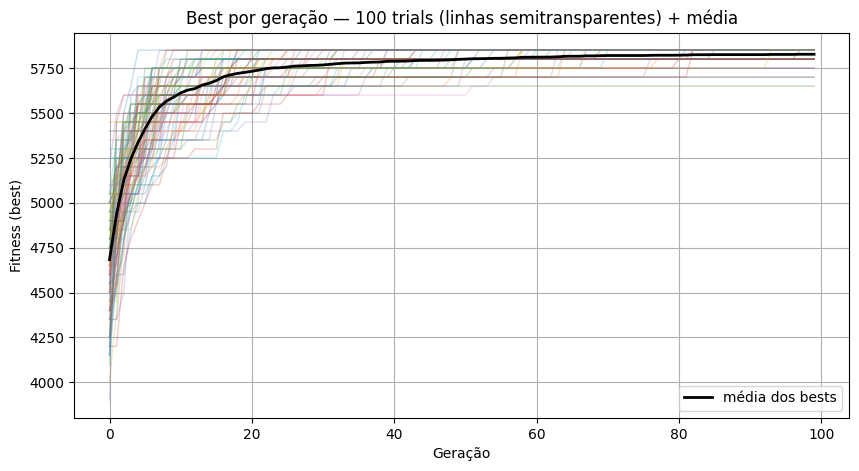

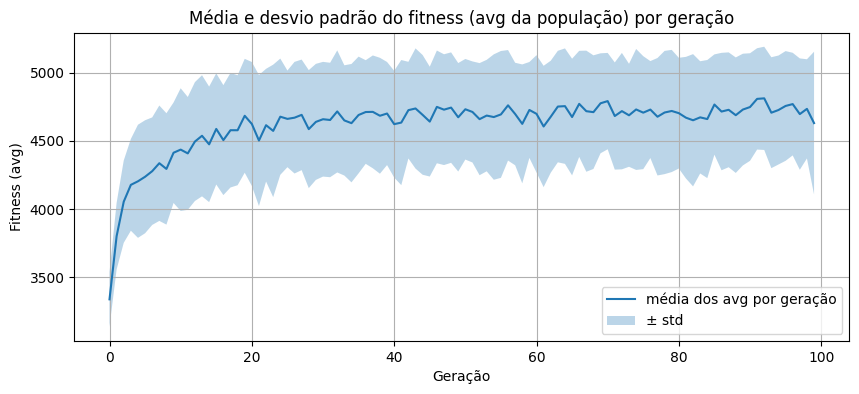

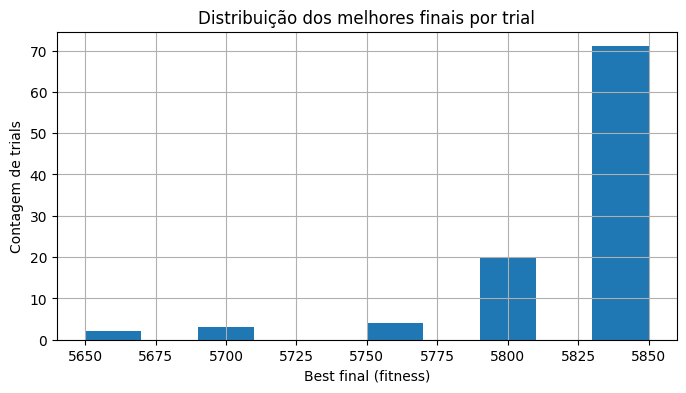

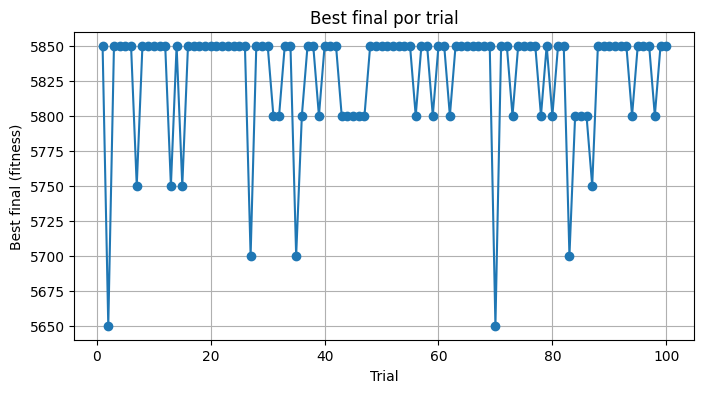


=== Resumo agregado ===
Média dos best finais: 5827.50
Mediana dos best finais: 5850.00
Melhor entre todos os trials: 5850 (trial 1)
Pior entre todos os trials: 5650 (trial 2)
Tempo total (s): 10.99


In [4]:
# ga_experiments_plot.py
"""
Roda vários trials do GA (versão simples) e EXIBE resultados com matplotlib.
Não salva CSVs.
Ajuste parâmetros na seção CONFIG.
"""

import time
import numpy as np
import matplotlib.pyplot as plt

# ------------- CONFIG -------------
N_TRIALS = 100
GERACOES = 100
POP_SIZE = 20
MUT_RATE = 0.05
TORNEIO = 3
ELITISMO = True
BASE_SEED = None    # None => seeds aleatórias
SHOW_INDIVIDUAL = False  # True para abrir um plot por trial (pode ser muitos)
# -----------------------------------

pesos_dos_objetos = np.array([350,250,160,120,200,100,120,220,40,80,100,300,180,250,220,150,280,310,120,160,110,210])
valor_dos_objetos = np.array([300,400,450,350,250,300,200,250,150,400,350,300,450,500,350,400,200,300,250,300,150,200])
PESO_MAX = 3000
GENOME = len(pesos_dos_objetos)

def fitness(ind):
    p = ind.dot(pesos_dos_objetos)
    v = ind.dot(valor_dos_objetos)
    return 0 if p > PESO_MAX else v

def torneio(pop, fits):
    idx = np.random.choice(len(pop), TORNEIO, replace=False)
    return pop[idx[np.argmax(fits[idx])]]

def crossover(a, b):
    pt = np.random.randint(1, GENOME-1)
    return np.concatenate((a[:pt], b[pt:])), np.concatenate((b[:pt], a[pt:]))

def muta(ind):
    for i in range(GENOME):
        if np.random.rand() < MUT_RATE:
            ind[i] = 1 - ind[i]
    return ind

def run_trial(seed=None):
    if seed is not None:
        np.random.seed(seed)
    pop = np.random.randint(2, size=(POP_SIZE, GENOME)).astype(int)
    best_global = 0
    best_sol = np.zeros(GENOME, dtype=int)
    gen_best = 0

    bests = np.zeros(GERACOES, dtype=int)
    avgs  = np.zeros(GERACOES, dtype=float)
    worst = np.zeros(GERACOES, dtype=int)

    t0 = time.time()
    for g in range(GERACOES):
        fits = np.array([fitness(ind) for ind in pop])
        bests[g] = int(fits.max())
        avgs[g]  = float(fits.mean())
        worst[g] = int(fits.min())

        if fits.max() > best_global:
            best_global = int(fits.max())
            best_sol = pop[np.argmax(fits)].copy()
            gen_best = g

        # reprodução
        if ELITISMO:
            elite = pop[np.argmax(fits)].copy()
            new_pop = [elite]
            while len(new_pop) < POP_SIZE:
                p1 = torneio(pop, fits)
                p2 = torneio(pop, fits)
                c1, c2 = crossover(p1, p2)
                new_pop.append(muta(c1.astype(int)))
                if len(new_pop) < POP_SIZE:
                    new_pop.append(muta(c2.astype(int)))
            pop = np.array(new_pop[:POP_SIZE])
        else:
            new_pop = []
            while len(new_pop) < POP_SIZE:
                p1 = torneio(pop, fits)
                p2 = torneio(pop, fits)
                c1, c2 = crossover(p1, p2)
                new_pop.append(muta(c1.astype(int)))
                if len(new_pop) < POP_SIZE:
                    new_pop.append(muta(c2.astype(int)))
            pop = np.array(new_pop[:POP_SIZE])

    t1 = time.time()
    peso = int(best_sol.dot(pesos_dos_objetos))
    return {
        "best_final": best_global,
        "geracao_do_best": gen_best,
        "peso_total": peso,
        "tempo": t1 - t0,
        "bests": bests,
        "avgs": avgs,
        "worst": worst
    }

def main():
    all_bests = np.zeros((N_TRIALS, GERACOES), dtype=int)
    all_avgs  = np.zeros((N_TRIALS, GERACOES), dtype=float)
    final_bests = np.zeros(N_TRIALS, dtype=int)
    gen_of_best  = np.zeros(N_TRIALS, dtype=int)
    tempos = np.zeros(N_TRIALS, dtype=float)
    pesos = np.zeros(N_TRIALS, dtype=int)

    for i in range(N_TRIALS):
        seed = None if BASE_SEED is None else BASE_SEED + i
        r = run_trial(seed=seed)
        all_bests[i,:] = r["bests"]
        all_avgs[i,:]  = r["avgs"]
        final_bests[i] = r["best_final"]
        gen_of_best[i] = r["geracao_do_best"]
        tempos[i] = r["tempo"]
        pesos[i] = r["peso_total"]
        print(f"Trial {i+1:02d}: best={final_bests[i]} gen={gen_of_best[i]} time={tempos[i]:.2f}s peso={pesos[i]}")

        if SHOW_INDIVIDUAL:
            plt.figure(figsize=(8,3))
            plt.plot(r["bests"], label="best")
            plt.plot(r["avgs"],  label="avg")
            plt.title(f"Trial {i+1:02d} — best final {final_bests[i]}")
            plt.xlabel("Geração")
            plt.ylabel("Fitness")
            plt.legend()
            plt.grid(True)
            plt.show()

    # Plot 1: linhas de best por geração (cada trial) + média
    plt.figure(figsize=(10,5))
    for i in range(N_TRIALS):
        plt.plot(all_bests[i], alpha=0.25, linewidth=1)
    mean_bests = all_bests.mean(axis=0)
    plt.plot(mean_bests, color="black", linewidth=2, label="média dos bests")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (best)")
    plt.title(f"Best por geração — {N_TRIALS} trials (linhas semitransparentes) + média")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: média ± std do fitness da população por geração
    mean_avgs = all_avgs.mean(axis=0)
    std_avgs  = all_avgs.std(axis=0)
    plt.figure(figsize=(10,4))
    plt.plot(mean_avgs, label="média dos avg por geração")
    plt.fill_between(np.arange(GERACOES), mean_avgs - std_avgs, mean_avgs + std_avgs, alpha=0.3, label="± std")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (avg)")
    plt.title("Média e desvio padrão do fitness (avg da população) por geração")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: histograma dos melhores finais
    plt.figure(figsize=(8,4))
    plt.hist(final_bests, bins='auto')
    plt.xlabel("Best final (fitness)")
    plt.ylabel("Contagem de trials")
    plt.title("Distribuição dos melhores finais por trial")
    plt.grid(True)
    plt.show()

    # Plot 4: best por trial (scatter)
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(1, N_TRIALS+1), final_bests, marker='o', linestyle='-')
    plt.xlabel("Trial")
    plt.ylabel("Best final (fitness)")
    plt.title("Best final por trial")
    plt.grid(True)
    plt.show()

    # Print resumo estatístico
    print("\n=== Resumo agregado ===")
    print(f"Média dos best finais: {final_bests.mean():.2f}")
    print(f"Mediana dos best finais: {np.median(final_bests):.2f}")
    print(f"Melhor entre todos os trials: {final_bests.max()} (trial {np.argmax(final_bests)+1})")
    print(f"Pior entre todos os trials: {final_bests.min()} (trial {np.argmin(final_bests)+1})")
    print(f"Tempo total (s): {tempos.sum():.2f}")

if __name__ == "__main__":
    main()
